In [1]:
import sys
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

#Code from existing github repo provided by UC Irvine dataset
sys.path.append(os.getcwd())
import utils
import equalizer
from utils import cutCube
from equalizer import histEq

In [2]:
# Modified DICOM loading functions for newer pydicom versions
def load_scan(path2scan):
    if (path2scan.split('.')[-1] == 'mhd') or (path2scan.split('.')[-1] == 'raw'):
        return load_mhd(path2scan)
    elif path2scan.split('.')[-1] == 'dcm':
        return load_dicom(os.path.split(path2scan)[0]) #pass containing directory
    elif os.path.isdir(path2scan) and any(f.endswith('.dcm') for f in os.listdir(path2scan)):
        return load_dicom(path2scan)
    else:
        raise Exception('No valid scan [series] found in given file/directory')

def load_mhd(path2scan):
    itkimage = sitk.ReadImage(path2scan)
    scan = sitk.GetArrayFromImage(itkimage)
    spacing = np.flip(np.array(itkimage.GetSpacing()),axis=0)
    orientation = np.transpose(np.array(itkimage.GetDirection()).reshape((3, 3)))
    origin = np.flip(np.array(itkimage.GetOrigin()),axis=0)
    return scan, spacing, orientation, origin, None

def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    if not dcms:
        raise Exception(f"No DICOM files found in {dicom_folder}")

    first_slice_data = pydicom.dcmread(os.path.join(path2scan_dir, dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient)
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]])

    scan = np.zeros((len(dcms), first_slice.shape[0], first_slice.shape[1]))
    raw_slices = []
    indexes = []

    for dcm in dcms:
        slice_data = pydicom.dcmread(os.path.join(dicom_folder, dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))

    indexes = np.array(indexes, dtype=float)
    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]

    try:
        origin = np.array(raw_slices[0][0x00200032].value)
        origin = np.array([origin[2], origin[1], origin[0]])
    except:
        origin = np.zeros(3)

    for i, slice_obj in enumerate(raw_slices):
        scan[i, :, :] = slice_obj.pixel_array

    return scan, spacing, orientation, origin, raw_slices

def scale_scan(scan, spacing, factor=1):
    resize_factor = factor * spacing
    new_real_shape = scan.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / scan.shape
    new_spacing = spacing / real_resize_factor
    scan_resized = scipy.ndimage.zoom(scan, real_resize_factor, mode='nearest')
    return scan_resized, resize_factor

def get_scaled_shape(shape, spacing):
    new_real_shape = shape * spacing
    return np.round(new_real_shape).astype(int)

def world2vox(world_coord, spacing, orientation, origin):
    world_coord = np.dot(np.linalg.inv(np.dot(orientation, np.diag(spacing))), world_coord - origin)
    if orientation[0, 0] < 0:
        vox_coord = (np.array([world_coord[0], world_coord[2], world_coord[1]])).astype(int)
    else:
        vox_coord = (np.array([world_coord[0], world_coord[1], world_coord[2]])).astype(int)
    return vox_coord

In [3]:
class CombinedLabeledExtractor:
    """
    Extractor that combines multiple experiments into one dataset
    Modified to split data BEFORE augmentation
    """
    def __init__(self,
                 experiments_config,
                 dst_path,
                 norm_save_dir,
                 cube_shape=(32, 32, 32),
                 parallelize=False,
                 coordSystem='vox',
                 include_types=['FB', 'FM', 'TM','TB'],
                 augment=True,
                 train_ratio=0.6,
                 val_ratio=0.2,
                 test_ratio=0.2,
                 random_state=42):
        """
        Args:
            experiments_config: List of experiment configurations
            dst_path: Where to save the combined processed dataset
            norm_save_dir: Where to save normalization parameters
            cube_shape: Size of extracted 3D cubes
            parallelize: Whether to use multiprocessing
            coordSystem: 'vox' for voxel coordinates
            include_types: Which finding types to include
            augment: Whether to perform data augmentation (only on training set)
            train_ratio: Proportion of data for training
            val_ratio: Proportion of data for validation
            test_ratio: Proportion of data for testing
            random_state: Random seed for reproducibility
        """
        self.experiments_config = experiments_config
        self.dst_path = dst_path
        self.norm_save_dir = norm_save_dir
        self.cube_shape = cube_shape
        self.parallelize = parallelize
        self.coordSystem = coordSystem
        self.include_types = include_types
        self.augment = augment
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state

        # Load and combine labels from all experiments
        self.combined_labels_df = pd.DataFrame()

        for exp_config in experiments_config:
            print(f"\nLoading labels for {exp_config['experiment_name']}...")

            # Load labels for this experiment
            labels_df = pd.read_csv(exp_config['labels_csv'])

            # Add experiment identifier
            labels_df['experiment'] = exp_config['experiment_name']
            labels_df['dicom_base_dir'] = exp_config['dicom_dir']

            # Filter by type
            labels_df = labels_df[labels_df['type'].isin(include_types)]

            # Filter out TB entries with 0,0,0 coordinates
            # labels_df = labels_df[~((labels_df['type'] == 'TB') &
            #                        (labels_df['x'] == 0) &
            #                        (labels_df['y'] == 0) &
            #                        (labels_df['slice'] == 0))]
            #
            print(f"Loaded {len(labels_df)} samples from {exp_config['experiment_name']}")
            print(f"Types distribution:\n{labels_df['type'].value_counts()}")

            # Combine with existing labels
            self.combined_labels_df = pd.concat([self.combined_labels_df, labels_df],
                                                ignore_index=True)

        print(f"\nTotal combined samples: {len(self.combined_labels_df)}")
        print(f"Combined types distribution:\n{self.combined_labels_df['type'].value_counts()}")
        print(f"Samples per experiment:\n{self.combined_labels_df['experiment'].value_counts()}")

    def extract(self, plot=True):
        """Extract and process all labeled samples from all experiments"""
        print("\nPreparing extraction jobs for combined dataset...")

        # create train/val/test split on the original data
        train_df, val_df, test_df = self._create_data_splits()

        # Process each split separately
        splits_data = {}

        for split_name, split_df, apply_augment in [
            ('train', train_df, self.augment),
            ('val', val_df, False),
            ('test', test_df, False)
        ]:
            print(f"\n{'='*50}")
            print(f"Processing {split_name} set ({len(split_df)} samples)...")
            print(f"Augmentation: {'ON' if apply_augment else 'OFF'}")

            instances, labels, experiments = self._process_split(split_df, apply_augment)

            if len(instances) == 0:
                print(f"ERROR: No instances were successfully extracted for {split_name}!")
                continue

            splits_data[split_name] = {
                'instances': instances,
                'labels': labels,
                'experiments': experiments
            }

            print(f"Successfully extracted {len(instances)} instances for {split_name}")

        # Combine all splits for normalization (but keep track of indices)
        all_instances = []
        split_indices = {}
        current_idx = 0

        for split_name in ['train', 'val', 'test']:
            if split_name in splits_data:
                split_size = len(splits_data[split_name]['instances'])
                split_indices[split_name] = (current_idx, current_idx + split_size)
                all_instances.extend(splits_data[split_name]['instances'])
                current_idx += split_size

        all_instances = np.array(all_instances)

        # Preprocessing on all data
        print("\n\nEqualizing the data across all splits...")
        eq = histEq(all_instances)
        all_instances = eq.equalize(all_instances)
        os.makedirs(self.norm_save_dir, exist_ok=True)
        eq.save(path=os.path.join(self.norm_save_dir, 'equalization.pkl'))

        print("Normalizing the data...")
        min_v = np.min(all_instances)
        max_v = np.max(all_instances)
        mean_v = np.mean(all_instances)
        norm_data = np.array([mean_v, min_v, max_v])
        all_instances = (all_instances - mean_v) / (max_v - min_v)
        np.save(os.path.join(self.norm_save_dir, 'normalization.npy'), norm_data)

        # Split back the normalized data
        for split_name, (start_idx, end_idx) in split_indices.items():
            splits_data[split_name]['instances'] = all_instances[start_idx:end_idx]

        # Save each split separately
        print("\n\nSaving the split datasets...")

        for split_name in ['train', 'val', 'test']:
            if split_name in splits_data:
                split_path = self.dst_path.replace('.npy', f'_{split_name}.npy')
                np.save(split_path, splits_data[split_name]['instances'])
                np.save(split_path.replace('.npy', '_labels.npy'), splits_data[split_name]['labels'])
                np.save(split_path.replace('.npy', '_experiments.npy'), splits_data[split_name]['experiments'])

                print(f"Saved {split_name} set: {len(splits_data[split_name]['instances'])} samples")

        # Save metadata
        metadata = {
            'label_mapping': {label: int(idx) for idx, label in enumerate(np.unique(self.combined_labels_df['type']))},
            'experiment_info': {exp: int(idx) for idx, exp in enumerate(np.unique(self.combined_labels_df['experiment']))},
            'split_sizes': {
                split_name: len(splits_data[split_name]['instances'])
                for split_name in splits_data
            },
            'split_ratios': {
                'train': self.train_ratio,
                'val': self.val_ratio,
                'test': self.test_ratio
            },
            'augmentation_applied': {
                'train': self.augment,
                'val': False,
                'test': False
            },
            'random_state': self.random_state
        }

        import json
        with open(self.dst_path.replace('.npy', '_metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"\nLabel mapping: {metadata['label_mapping']}")
        print(f"Experiment mapping: {metadata['experiment_info']}")
        print(f"\nFinal split sizes:")
        for split_name, size in metadata['split_sizes'].items():
            print(f"  {split_name}: {size} samples")

        if plot:
            self._plot_split_distributions(splits_data)

        return splits_data, metadata

    def _create_data_splits(self):
        """Create train/val/test splits with stratification"""
        print("\nCreating train/val/test splits...")

        # Create stratification key combining type and experiment
        self.combined_labels_df['stratify_key'] = (
            self.combined_labels_df['type'] + '_' +
            self.combined_labels_df['experiment']
        )

        # First split: train+val vs test
        train_val_df, test_df = train_test_split(
            self.combined_labels_df,
            test_size=self.test_ratio,
            stratify=self.combined_labels_df['stratify_key'],
            random_state=self.random_state
        )

        # Second split: train vs val
        val_size_adjusted = self.val_ratio / (self.train_ratio + self.val_ratio)
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            stratify=train_val_df['stratify_key'],
            random_state=self.random_state
        )

        print(f"Split sizes:")
        print(f"  Train: {len(train_df)} samples ({len(train_df)/len(self.combined_labels_df)*100:.1f}%)")
        print(f"  Val: {len(val_df)} samples ({len(val_df)/len(self.combined_labels_df)*100:.1f}%)")
        print(f"  Test: {len(test_df)} samples ({len(test_df)/len(self.combined_labels_df)*100:.1f}%)")

        # Print distribution per split
        for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
            print(f"\n{split_name} set distribution:")
            print(split_df['type'].value_counts())

        return train_df, val_df, test_df

    def _process_split(self, split_df, apply_augment):
        """Process a single data split"""
        jobs = []
        labels = []
        experiments = []

        for idx, row in split_df.iterrows():
            # Build path to DICOM scan
            scan_path = os.path.join(row['dicom_base_dir'], str(row['uuid']))
            scan_path = os.path.normpath(scan_path)

            # Coordinate in z,y,x format
            coord = np.array([row['slice'], row['y'], row['x']])

            # Job format: [scan_path, coord, cube_shape, coordSystem, label_type, apply_augment]
            jobs.append([scan_path, coord, self.cube_shape, self.coordSystem, row['type'], apply_augment])
            labels.append(row['type'])
            experiments.append(row['experiment'])

        print(f"Extracting {len(jobs)} samples...")

        if self.parallelize:
            num_cores = int(np.ceil(min(np.ceil(multiprocessing.cpu_count() * 0.75), len(jobs))))
            results = Parallel(n_jobs=num_cores)(delayed(self._process_job)(job) for job in jobs)
        else:
            results = []
            for i, job in enumerate(jobs):
                try:
                    result = self._process_job(job)
                    results.append(result)
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(jobs)} samples")
                except Exception as e:
                    print(f"Failed to process sample {job[0]}: {e}")
                    results.append(None)

        # Collect successful extractions
        instances = []
        instance_labels = []
        instance_experiments = []

        for i, result in enumerate(results):
            if result is not None:
                cubes, label_type = result
                instances.extend(cubes)
                instance_labels.extend([label_type] * len(cubes))
                instance_experiments.extend([experiments[i]] * len(cubes))

        return np.array(instances), np.array(instance_labels), np.array(instance_experiments)

    def _process_job(self, args):
        """Process single extraction job"""
        scan_path, coord, cube_shape, coordSystem, label_type, apply_augment = args

        try:
            # Load scan
            scan, spacing, orientation, origin, raw_slices = load_scan(scan_path)

            # Convert coordinates if needed
            if coordSystem == 'world':
                coord = world2vox(coord, spacing, orientation, origin)

            # Extract the base cube with padding
            init_cube_shape = get_scaled_shape(np.array(cube_shape) + 8, 1/spacing)
            clean_cube_unscaled = cutCube(scan, coord, init_cube_shape, padd=-1000)

            # Scale the cube
            scaled_cube, resize_factor = scale_scan(clean_cube_unscaled, spacing)

            # Data augmentation (only if specified)
            if apply_augment:
                augmented_cubes = self._augment_instance(scaled_cube)
            else:
                augmented_cubes = [scaled_cube]

            # Trim to final shape
            final_cubes = []
            for cube in augmented_cubes:
                center = np.array(cube.shape) // 2
                final_cube = cutCube(cube, center, cube_shape, padd=-1000)
                if final_cube.shape == tuple(cube_shape):
                    final_cubes.append(final_cube)

            return final_cubes, label_type

        except Exception as e:
            print(f"Error processing {scan_path}: {e}")
            return None

    def _augment_instance(self, x0):
        """Data augmentation"""
        augmented = [x0]  # Original

        # Flips
        augmented.append(np.flip(x0, 1))  # x flip
        augmented.append(np.flip(x0, 2))  # y flip

        # Small shifts
        augmented.append(scipy.ndimage.shift(x0, (0, 2, 2), mode='constant'))
        augmented.append(scipy.ndimage.shift(x0, (0, -2, 2), mode='constant'))

        # Small rotations
        for angle in [15, 30, 45, 90, 180]:
            rotated = rotate(x0, angle, axes=(1, 2), mode='reflect', reshape=False)
            augmented.append(rotated)

        # Filter out invalid shapes
        valid_cubes = []
        for cube in augmented:
            if cube.shape[0] > 0 and cube.shape[1] > 0 and cube.shape[2] > 0:
                valid_cubes.append(cube)

        return valid_cubes

    def _plot_split_distributions(self, splits_data):
        """Plot distributions for each split"""
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: Sample counts per split
        split_names = list(splits_data.keys())
        split_sizes = [len(splits_data[s]['instances']) for s in split_names]

        axes[0, 0].bar(split_names, split_sizes, color=['#2E86AB', '#A23B72', '#F18F01'])
        axes[0, 0].set_title('Sample Count per Split', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Number of Samples')

        for i, (name, size) in enumerate(zip(split_names, split_sizes)):
            axes[0, 0].text(i, size + 10, str(size), ha='center', fontweight='bold')

        # Plot 2: Type distribution per split
        width = 0.25
        x = np.arange(len(split_names))

        unique_types = ['FB', 'FM', 'TM','TB']
        colors = {'FB': '#FF6B6B', 'FM': '#4ECDC4', 'TM': '#45B7D1','TB':'#6BFFFF'}

        for i, ttype in enumerate(unique_types):
            counts = []
            for split_name in split_names:
                type_count = np.sum(splits_data[split_name]['labels'] == ttype)
                counts.append(type_count)

            axes[0, 1].bar(x + i*width, counts, width, label=ttype, color=colors[ttype])

        axes[0, 1].set_xlabel('Split')
        axes[0, 1].set_ylabel('Number of Samples')
        axes[0, 1].set_title('Type Distribution per Split', fontsize=14, fontweight='bold')
        axes[0, 1].set_xticks(x + width)
        axes[0, 1].set_xticklabels(split_names)
        axes[0, 1].legend()

        # Plot 3: Experiment distribution per split
        unique_experiments = ['Experiment_1', 'Experiment_2']
        exp_colors = ['#8B5A3C', '#6B8E23']

        for i, exp in enumerate(unique_experiments):
            counts = []
            for split_name in split_names:
                exp_count = np.sum(splits_data[split_name]['experiments'] == exp)
                counts.append(exp_count)

            axes[1, 0].bar(x + i*width*1.5, counts, width*1.5, label=exp, color=exp_colors[i])

        axes[1, 0].set_xlabel('Split')
        axes[1, 0].set_ylabel('Number of Samples')
        axes[1, 0].set_title('Experiment Distribution per Split', fontsize=14, fontweight='bold')
        axes[1, 0].set_xticks(x + width*0.75)
        axes[1, 0].set_xticklabels(split_names)
        axes[1, 0].legend()

        # Plot 4: Augmentation effect (for training set)
        if 'train' in splits_data:
            train_labels = splits_data['train']['labels']
            unique_labels, counts = np.unique(train_labels, return_counts=True)

            # Estimate original counts (before augmentation)
            # This is approximate based on the augmentation factor
            original_train_size = len(self.combined_labels_df) * self.train_ratio
            augmentation_factor = len(train_labels) / original_train_size

            axes[1, 1].text(0.5, 0.5, f'Training Set Augmentation\n\nOriginal: ~{int(original_train_size)} samples\n'
                           f'After Augmentation: {len(train_labels)} samples\n'
                           f'Augmentation Factor: ~{augmentation_factor:.1f}x',
                           ha='center', va='center', fontsize=12,
                           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            axes[1, 1].set_title('Augmentation Summary', fontsize=14, fontweight='bold')
            axes[1, 1].axis('off')

        plt.tight_layout()
        plt.suptitle('Data Split Analysis', fontsize=16, fontweight='bold', y=1.02)
        plt.show()


In [4]:
class CombinedDataLoader:
    """
    Data loader for combined dataset with split support
    """
    def __init__(self, dataset_base_path, normdata_path, img_res=(32, 32, 32)):
        self.dataset_base_path = dataset_base_path
        self.normdata_path = normdata_path
        self.img_res = img_res
        self.splits = {}

        # Load metadata
        import json
        metadata_path = dataset_base_path.replace('.npy', '_metadata.json')
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)

        # Load each split
        for split in ['train', 'val', 'test']:
            split_path = dataset_base_path.replace('.npy', f'_{split}.npy')
            if os.path.exists(split_path):
                print(f"\nLoading {split} set...")

                data = np.load(split_path)
                labels = np.load(split_path.replace('.npy', '_labels.npy'))
                experiments = np.load(split_path.replace('.npy', '_experiments.npy'))

                # Format for neural network
                data = data.reshape((len(data), self.img_res[0], self.img_res[1], self.img_res[2], 1))

                # Convert labels to indices
                label_to_idx = self.metadata['label_mapping']
                label_indices = np.array([label_to_idx[label] for label in labels])

                self.splits[split] = {
                    'data': data,
                    'labels': labels,
                    'label_indices': label_indices,
                    'experiments': experiments
                }

                print(f"Loaded {len(data)} samples for {split}")
                print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")

    def get_split(self, split_name):
        """Get a specific split"""
        if split_name not in self.splits:
            raise ValueError(f"Split '{split_name}' not found. Available splits: {list(self.splits.keys())}")
        return self.splits[split_name]

    def load_batch(self, split_name='train', batch_size=32, shuffle=True):
        """Load batches from a specific split"""
        if split_name not in self.splits:
            raise ValueError(f"Split '{split_name}' not found")

        split_data = self.splits[split_name]
        data = split_data['data']
        labels = split_data['label_indices']

        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        n_batches = len(indices) // batch_size

        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = data[batch_indices]
            batch_labels = labels[batch_indices]

            yield batch_data, batch_labels

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
def pick_tb_voxel_from_lung_only(lung_coords, margin=16, volume_shape=None):

    lung_coords = np.array(lung_coords)

    if volume_shape is not None:
        z_max, y_max, x_max = volume_shape
        safe_mask = (
            (lung_coords[:, 0] >= margin) & (lung_coords[:, 0] < z_max - margin) &
            (lung_coords[:, 1] >= margin) & (lung_coords[:, 1] < y_max - margin) &
            (lung_coords[:, 2] >= margin) & (lung_coords[:, 2] < x_max - margin)
        )
        lung_coords = lung_coords[safe_mask]

    if len(lung_coords) == 0:
        raise ValueError("No safe TB voxel found in lung.")

    # Pick a random safe point
    idx = np.random.choice(len(lung_coords))
    return lung_coords[idx].tolist()

In [7]:
def extract_patient_info(exp):
    exp_tb_rows = exp[exp['type'] == 'TB']
    exp_non_tb_rows = exp[exp['type'].isin(['FB','FM','TM'])]

    tb_patient_ids = list(exp_tb_rows['uuid'])
    print(tb_patient_ids)
    return tb_patient_ids,exp_non_tb_rows

In [8]:
import SimpleITK as sitk
import lungmask
from lungmask import mask
from lungmask import LMInferer

def generate_TB_coords(patient_ids, exp):
    reader = sitk.ImageSeriesReader()

    inferer = LMInferer(batch_size=1)  # or device='cuda' if you have a GPU
    patient_id_coords = {}
    for tb_patient_id in patient_ids:
        dicom_names = reader.GetGDCMSeriesFileNames(os.path.join(exp,str(tb_patient_id)))
        reader.SetFileNames(dicom_names)
        ct_image = reader.Execute()
        lung_mask = inferer.apply(ct_image)  # returns SimpleITK.Image
        lung_coords = np.argwhere(lung_mask == 1)
        volume_shape = lung_mask.shape

        tb_coord = pick_tb_voxel_from_lung_only(lung_coords, margin=16, volume_shape=volume_shape)
        patient_id_coords[str(tb_patient_id)] = tb_coord
        print(f'TB coordinate for patient {tb_patient_id}: {tb_coord}')
    return patient_id_coords

In [9]:
def build_final_label_csv(patient_id_coords,exp_non_tb_rows,exp_name):
    rows = []
    for k,v in patient_id_coords.items():
        rows.append({
            'type':'TB',
            'uuid':k,
            'slice':v[0],
            'x':v[2],
            'y':v[1],

        })
    tb_rows = pd.DataFrame(rows)
    adj_exp_df = pd.concat([exp_non_tb_rows, tb_rows],ignore_index=True)
    adj_exp_df.to_csv(f'labels_{exp_name}_TB.csv')

In [10]:
# Generalized code to update the TB
exp1 = pd.read_csv(os.path.expanduser("~/PycharmProjects/PythonProject/MIDS_207_Final_Project/deepfakes+medical+image+tamper+detection/data/Tampered Scans/labels_exp1.csv"))
exp2 = pd.read_csv(os.path.expanduser("~/PycharmProjects/PythonProject/MIDS_207_Final_Project/deepfakes+medical+image+tamper+detection/data/Tampered Scans/labels_exp2.csv"))
exp1_dicom_parent_folder = os.path.expanduser("~/PycharmProjects/PythonProject/MIDS_207_Final_Project/deepfakes+medical+image+tamper+detection/data/Tampered Scans/Experiment 1 - Blind")
exp2_dicom_parent_folder = os.path.expanduser("~/PycharmProjects/PythonProject/MIDS_207_Final_Project/deepfakes+medical+image+tamper+detection/data/Tampered Scans/Experiment 2 - Open")
exp_count = 0
for exp in [(exp1,exp1_dicom_parent_folder), (exp2,exp2_dicom_parent_folder)]:
    patient_ids,exp_non_tb_rows = extract_patient_info(exp[0])
    patient_id_coords = generate_TB_coords(patient_ids, exp[1])
    build_final_label_csv(patient_id_coords,exp_non_tb_rows,''.join(['exp_',str(exp_count)]))
    exp_count += 1

[6644, 1531, 1779, 1779, 1779, 1779, 1632, 2925, 2104, 2104, 2104, 4474, 6080, 3361, 1840]
lungmask 2025-08-07 14:05:14 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


100%|██████████| 163/163.0 [00:40<00:00,  4.07it/s]

lungmask 2025-08-07 14:05:58 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 109.35it/s]


TB coordinate for patient 6644: [141, 278, 162]


100%|██████████| 129/129.0 [00:29<00:00,  4.31it/s]

lungmask 2025-08-07 14:06:33 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 599.74it/s]


TB coordinate for patient 1531: [59, 150, 128]


100%|██████████| 133/133.0 [00:30<00:00,  4.31it/s]

lungmask 2025-08-07 14:07:10 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 605.54it/s]


TB coordinate for patient 1779: [80, 282, 256]


100%|██████████| 133/133.0 [00:31<00:00,  4.26it/s]

lungmask 2025-08-07 14:07:45 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 587.07it/s]


TB coordinate for patient 1779: [103, 331, 206]


100%|██████████| 133/133.0 [00:31<00:00,  4.27it/s]

lungmask 2025-08-07 14:08:19 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 661.61it/s]


TB coordinate for patient 1779: [56, 380, 162]


100%|██████████| 133/133.0 [00:31<00:00,  4.28it/s]

lungmask 2025-08-07 14:08:54 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 630.30it/s]


TB coordinate for patient 1779: [112, 219, 208]


100%|██████████| 237/237.0 [00:55<00:00,  4.27it/s]

lungmask 2025-08-07 14:09:56 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 48.70it/s]


TB coordinate for patient 1632: [190, 220, 191]


100%|██████████| 127/127.0 [00:29<00:00,  4.24it/s]

lungmask 2025-08-07 14:10:32 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 68.53it/s]


TB coordinate for patient 2925: [70, 278, 88]


100%|██████████| 117/117.0 [00:27<00:00,  4.23it/s]

lungmask 2025-08-07 14:11:04 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 75.16it/s]


TB coordinate for patient 2104: [57, 196, 127]


100%|██████████| 117/117.0 [00:26<00:00,  4.37it/s]

lungmask 2025-08-07 14:11:34 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 71.25it/s]


TB coordinate for patient 2104: [45, 356, 209]


100%|██████████| 117/117.0 [00:26<00:00,  4.35it/s]

lungmask 2025-08-07 14:12:04 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 78.92it/s]


TB coordinate for patient 2104: [78, 339, 157]


100%|██████████| 124/124.0 [00:28<00:00,  4.36it/s]

lungmask 2025-08-07 14:12:37 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 148.99it/s]


TB coordinate for patient 4474: [96, 354, 128]


100%|██████████| 278/278.0 [01:07<00:00,  4.09it/s]

lungmask 2025-08-07 14:13:52 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 88.37it/s]


TB coordinate for patient 6080: [80, 340, 124]


100%|██████████| 255/255.0 [00:59<00:00,  4.30it/s]

lungmask 2025-08-07 14:15:00 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 465.40it/s]


TB coordinate for patient 3361: [170, 210, 96]


100%|██████████| 116/116.0 [00:26<00:00,  4.34it/s]

lungmask 2025-08-07 14:15:34 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 623.69it/s]


TB coordinate for patient 1840: [87, 241, 210]
[3341, 1610, 1610, 2960, 1563, 2366]
lungmask 2025-08-07 14:15:38 An Apple Metal device is detected and will be used. Use --cpu to disable Metal and force running on CPU.


100%|██████████| 139/139.0 [00:31<00:00,  4.36it/s]

lungmask 2025-08-07 14:16:13 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 547.63it/s]


TB coordinate for patient 3341: [35, 320, 213]


100%|██████████| 133/133.0 [00:30<00:00,  4.35it/s]

lungmask 2025-08-07 14:16:48 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 970.23it/s]


TB coordinate for patient 1610: [75, 165, 236]


100%|██████████| 133/133.0 [00:30<00:00,  4.38it/s]

lungmask 2025-08-07 14:17:22 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 1004.38it/s]


TB coordinate for patient 1610: [92, 181, 182]


100%|██████████| 179/179.0 [00:40<00:00,  4.41it/s]

lungmask 2025-08-07 14:18:07 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 98.22it/s]


TB coordinate for patient 2960: [57, 293, 84]


100%|██████████| 484/484.0 [01:53<00:00,  4.27it/s]

lungmask 2025-08-07 14:20:13 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 25.08it/s]


TB coordinate for patient 1563: [206, 400, 191]


100%|██████████| 133/133.0 [00:30<00:00,  4.35it/s]

lungmask 2025-08-07 14:20:54 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 679.85it/s]


TB coordinate for patient 2366: [56, 312, 217]



Loading labels for Experiment_1...
Loaded 128 samples from Experiment_1
Types distribution:
type
FB    61
FM    34
TM    23
TB    10
Name: count, dtype: int64

Loading labels for Experiment_2...
Loaded 35 samples from Experiment_2
Types distribution:
type
TM    12
FB    11
FM     7
TB     5
Name: count, dtype: int64

Total combined samples: 163
Combined types distribution:
type
FB    72
FM    41
TM    35
TB    15
Name: count, dtype: int64
Samples per experiment:
experiment
Experiment_1    128
Experiment_2     35
Name: count, dtype: int64

Preparing extraction jobs for combined dataset...

Creating train/val/test splits...
Split sizes:
  Train: 97 samples (59.5%)
  Val: 33 samples (20.2%)
  Test: 33 samples (20.2%)

Train set distribution:
type
FB    44
FM    24
TM    20
TB     9
Name: count, dtype: int64

Val set distribution:
type
FB    14
FM     9
TM     7
TB     3
Name: count, dtype: int64

Test set distribution:
type
FB    14
TM     8
FM     8
TB     3
Name: count, dtype: int64

P

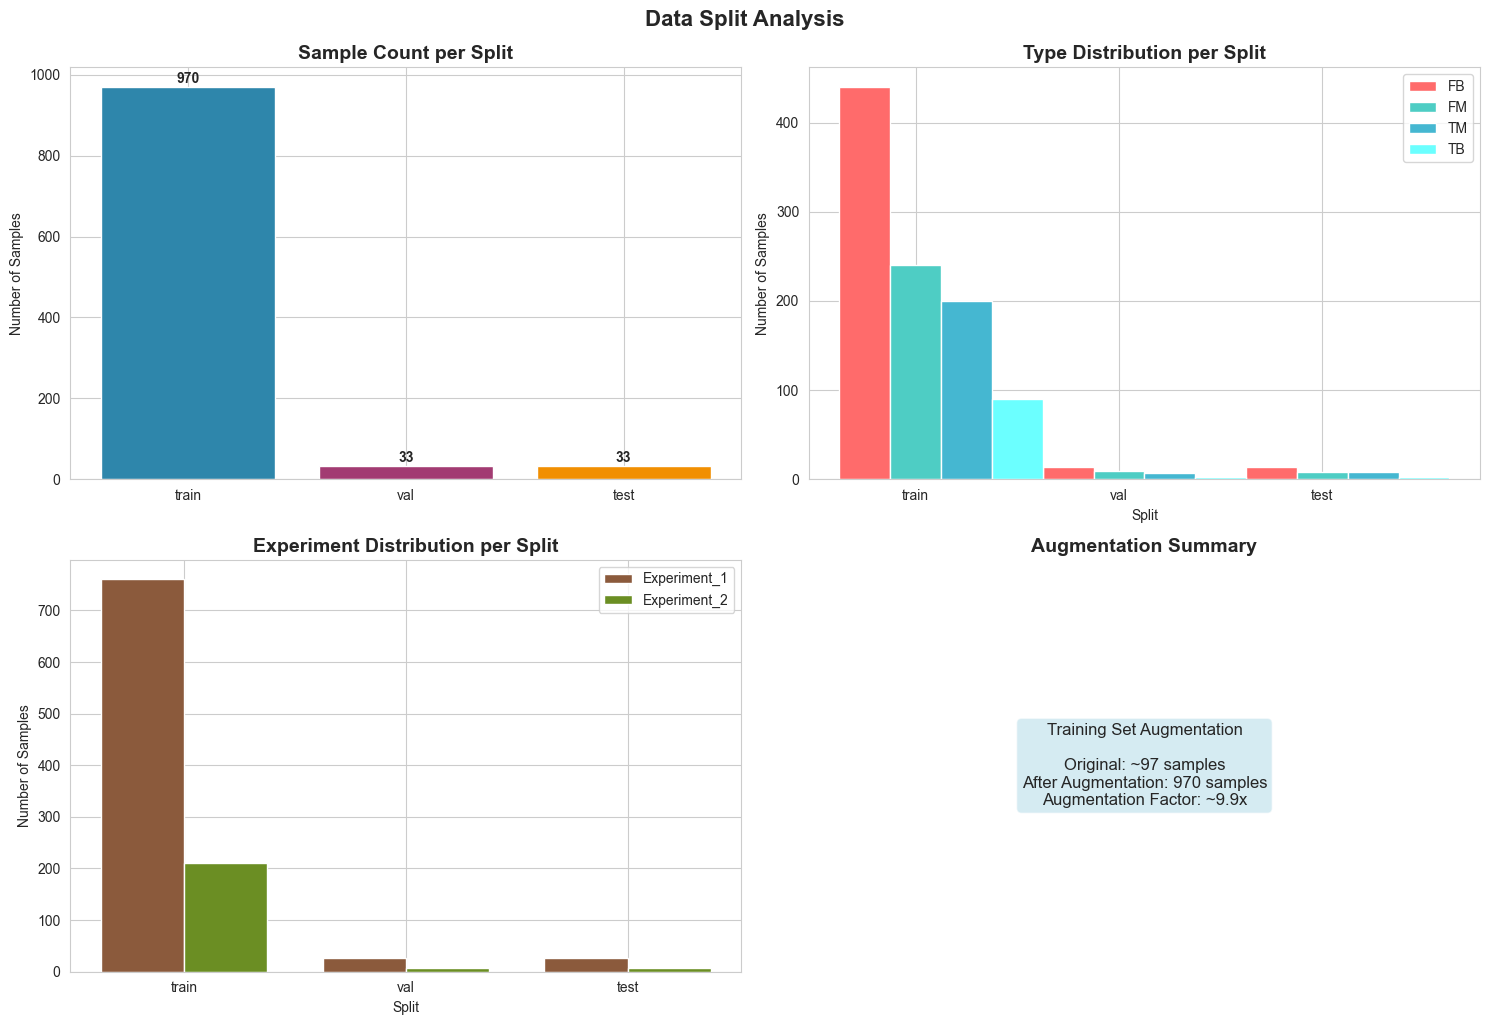


Loading train set...
Loaded 970 samples for train
Label distribution: {'FB': 440, 'FM': 240, 'TB': 90, 'TM': 200}

Loading val set...
Loaded 33 samples for val
Label distribution: {'FB': 14, 'FM': 9, 'TB': 3, 'TM': 7}

Loading test set...
Loaded 33 samples for test
Label distribution: {'FB': 14, 'FM': 8, 'TB': 3, 'TM': 8}


In [11]:
if __name__ == "__main__":
    # Configuration for combined dataset
    base_path = os.path.expanduser("~/PycharmProjects/PythonProject/MIDS_207_Final_Project/deepfakes+medical+image+tamper+detection/data/Tampered Scans/")

    # Define experiments configuration
    experiments_config = [
        {
            'labels_csv': os.path.join(base_path, "labels_exp_1_TB.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 1 - Blind"),
            'experiment_name': 'Experiment_1'
        },
        {
            'labels_csv': os.path.join(base_path, "labels_exp_2_TB.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 2 - Open"),
            'experiment_name': 'Experiment_2'
        }
    ]

    output_dataset = "combined_tampered_scans_dataset.npy"
    normalization_dir = "combined_tampered_scans_normalization"

    # Extract and preprocess combined dataset with split-first approach
    extractor = CombinedLabeledExtractor(
        experiments_config=experiments_config,
        dst_path=output_dataset,
        norm_save_dir=normalization_dir,
        cube_shape=(32, 32, 32),
        include_types=['FB', 'FM', 'TM','TB'],
        augment=True,  # Will only be applied to training set
        parallelize=False,
        train_ratio=0.6,
        val_ratio=0.2,
        test_ratio=0.2,
        random_state=42
    )

    splits_data, metadata = extractor.extract()

    # Load the split datasets
    if splits_data is not None:
        dataloader = CombinedDataLoader(
            dataset_base_path=output_dataset,
            normdata_path=normalization_dir
        )